<a href="https://colab.research.google.com/github/Tongwu18/fu-yao/blob/main/Halle_1_RL%2013%20%E7%A7%8D%E8%B4%A7%E6%9E%B6%20%20841%20%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import List, Tuple, Optional, Dict, Any
from dataclasses import dataclass, field
import copy

df = pd.read_excel("https://github.com/Tongwu18/fu-yao/raw/main/111.xlsx")
df

,玻璃索引,最短宽,高2,Count of 玻璃索引
0,1,112.0,35.0,28
1,2,112.0,35.0,13
2,3,180.0,102.0,30
3,4,180.0,102.0,15
4,5,180.0,102.0,8
...,...,...,...,...
696,697,115.0,79.5,1
697,698,114.0,63.0,1
698,699,209.0,64.0,1
699,700,143.0,64.0,15


原始玻璃种类: 701
总箱数: 12117

玻璃尺寸分布分析

高度 (H):
  范围: 35 - 161mm
  均值: 85.7mm
  唯一值: 96种

宽度 (W):
  范围: 37 - 209mm
  均值: 121.9mm
  唯一值: 82种

高度分位数:
  25%: 68mm
  50%: 81mm
  75%: 110mm
  90%: 116mm
  95%: 118mm
  99%: 130mm

宽度分位数:
  25%: 110mm
  50%: 121mm
  75%: 145mm
  90%: 163mm
  95%: 167mm
  99%: 177mm


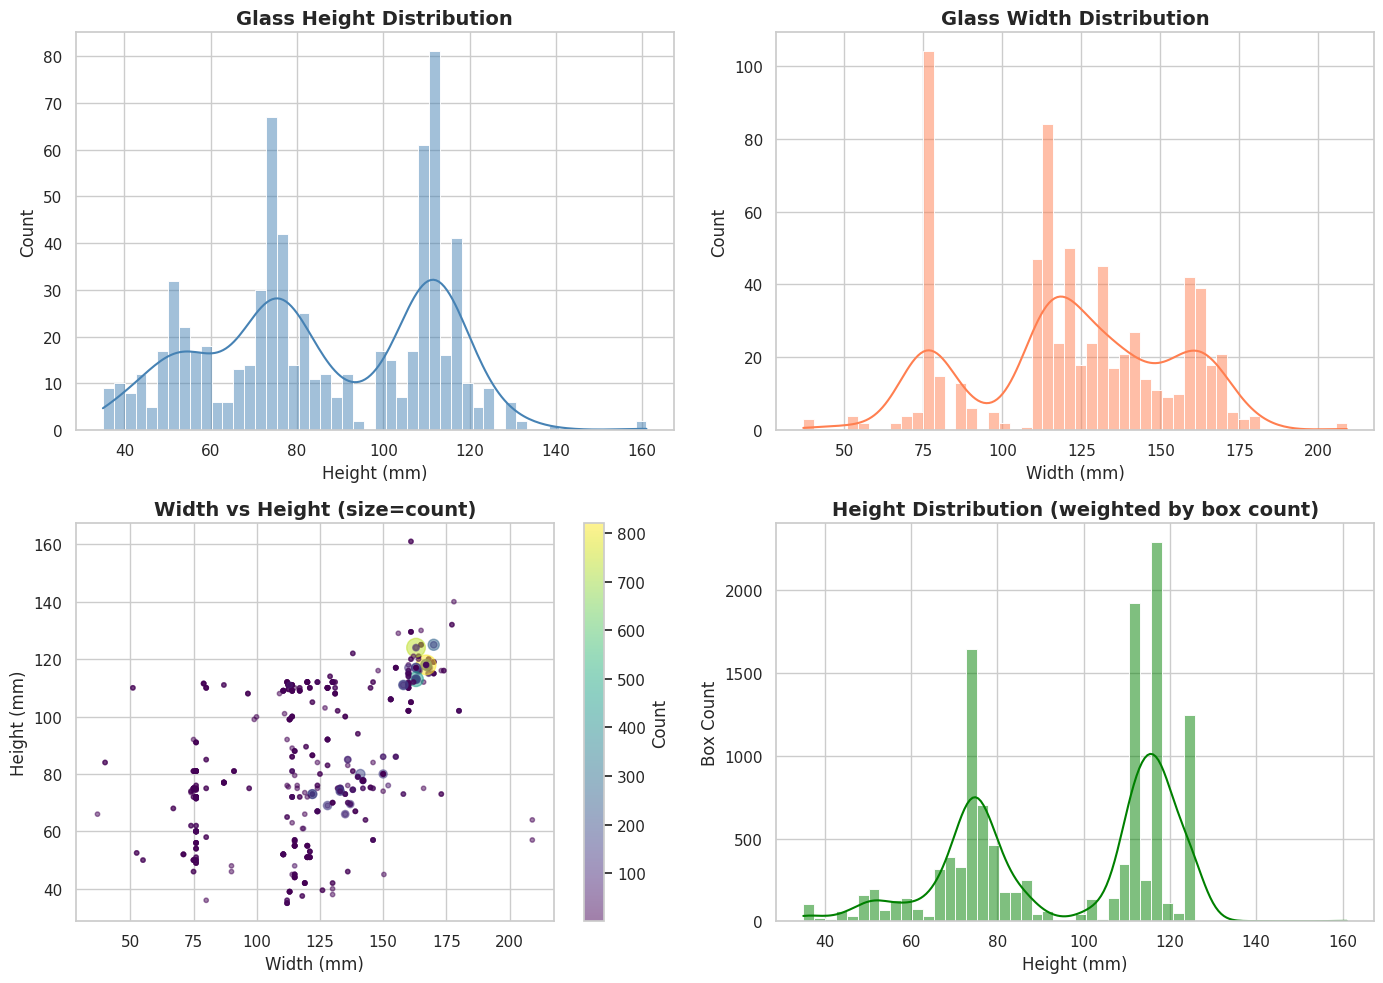


图表已保存: glass_distribution.png

搜索最优合并参数 (目标: 80-120种)

推荐参数: h_step=5mm, w_step=10mm
  合并后: 97种
  面积浪费: 5.1%

所有测试结果:
--------------------------------------------------
  h=25, w=25:  27种, 浪费18.1%
  h=25, w=20:  31种, 浪费17.5%
  h=20, w=25:  32种, 浪费16.1%
  h=20, w=20:  35种, 浪费15.5%
  h=25, w=15:  37种, 浪费14.6%
  h=15, w=25:  38种, 浪费14.6%
  h=20, w=15:  41种, 浪费12.6%
  h=15, w=20:  43种, 浪费14.1%
  h=25, w=10:  45种, 浪费12.9%
  h=10, w=25:  48种, 浪费12.9%
  h=15, w=15:  50种, 浪费11.2%
  h=20, w=10:  50种, 浪费10.9%
  h=10, w=20:  55种, 浪费12.3%
  h=15, w=10:  59种, 浪费9.5%
  h=10, w=15:  65种, 浪费9.5%
  h=25, w= 5:  65种, 浪费10.9%
  h= 5, w=25:  72种, 浪费9.9%
  h=10, w=10:  72种, 浪费7.9%
  h=20, w= 5:  72种, 浪费9.0%
  h= 5, w=20:  79种, 浪费9.4%
  h=15, w= 5:  80种, 浪费7.6%
  h= 5, w=15:  90种, 浪费6.7%
  h= 5, w=10:  97种, 浪费5.1%
  h=10, w= 5:  99种, 浪费6.0%
  h= 5, w= 5: 126种, 浪费3.3%

自适应合并 (目标: ~100种)

原始高度种类: 96
标准高度: 10种 -> [np.int64(50), np.int64(60), np.int64(70), np.int64(80), np.int64(95), np.int64(105), np.int64(11

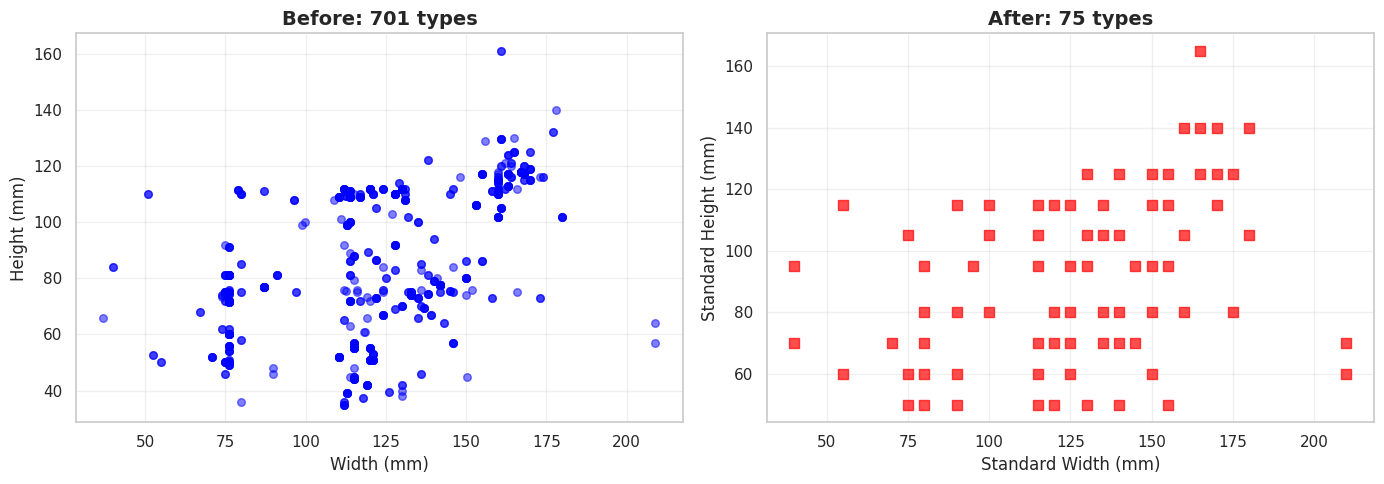


图表已保存: glass_merge_result.png


In [31]:
"""
玻璃规格合并优化
目标：将701种玻璃合并到约100种标准规格
原则：小的按大的来（向上取整）
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")


class GlassMerger:
    def __init__(self, df):
        """
        初始化

        参数:
            df: 原始玻璃数据（701种）
        """
        w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
        h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
        cnt_col = next((c for c in ['Count of 玻璃索引', 'count'] if c in df.columns), None)
        id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)

        self.df = df.copy()
        self.W = df[w_col].values.astype(float)
        self.H = df[h_col].values.astype(float)
        self.C = df[cnt_col].values.astype(int)
        self.ids = df[id_col].values if id_col else np.arange(len(df))

        self.w_col = w_col
        self.h_col = h_col
        self.cnt_col = cnt_col

        self.n = len(self.W)
        self.total_boxes = self.C.sum()

        print(f"原始玻璃种类: {self.n}")
        print(f"总箱数: {self.total_boxes}")

    def analyze_distribution(self):
        """分析高度和宽度分布"""
        print("\n" + "=" * 60)
        print("玻璃尺寸分布分析")
        print("=" * 60)

        print(f"\n高度 (H):")
        print(f"  范围: {self.H.min():.0f} - {self.H.max():.0f}mm")
        print(f"  均值: {self.H.mean():.1f}mm")
        print(f"  唯一值: {len(np.unique(self.H))}种")

        print(f"\n宽度 (W):")
        print(f"  范围: {self.W.min():.0f} - {self.W.max():.0f}mm")
        print(f"  均值: {self.W.mean():.1f}mm")
        print(f"  唯一值: {len(np.unique(self.W))}种")

        # 高度分位数
        print(f"\n高度分位数:")
        for p in [25, 50, 75, 90, 95, 99]:
            print(f"  {p}%: {np.percentile(self.H, p):.0f}mm")

        # 宽度分位数
        print(f"\n宽度分位数:")
        for p in [25, 50, 75, 90, 95, 99]:
            print(f"  {p}%: {np.percentile(self.W, p):.0f}mm")

        # 绘图
        self._plot_distribution()

        return {
            'h_unique': len(np.unique(self.H)),
            'w_unique': len(np.unique(self.W)),
            'h_range': (self.H.min(), self.H.max()),
            'w_range': (self.W.min(), self.W.max())
        }

    def _plot_distribution(self):
        """绘制分布图"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. 高度分布
        ax1 = axes[0, 0]
        sns.histplot(self.H, bins=50, kde=True, ax=ax1, color='steelblue')
        ax1.set_xlabel('Height (mm)', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.set_title('Glass Height Distribution', fontsize=14, fontweight='bold')

        # 2. 宽度分布
        ax2 = axes[0, 1]
        sns.histplot(self.W, bins=50, kde=True, ax=ax2, color='coral')
        ax2.set_xlabel('Width (mm)', fontsize=12)
        ax2.set_ylabel('Count', fontsize=12)
        ax2.set_title('Glass Width Distribution', fontsize=14, fontweight='bold')

        # 3. 高度 vs 宽度 散点图
        ax3 = axes[1, 0]
        sizes = np.clip(self.C / self.C.max() * 200, 10, 200)
        scatter = ax3.scatter(self.W, self.H, s=sizes, alpha=0.5, c=self.C, cmap='viridis')
        ax3.set_xlabel('Width (mm)', fontsize=12)
        ax3.set_ylabel('Height (mm)', fontsize=12)
        ax3.set_title('Width vs Height (size=count)', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax3, label='Count')

        # 4. 按数量加权的高度分布
        ax4 = axes[1, 1]
        # 展开成每个箱子
        all_heights = np.repeat(self.H, self.C)
        sns.histplot(all_heights, bins=50, kde=True, ax=ax4, color='green')
        ax4.set_xlabel('Height (mm)', fontsize=12)
        ax4.set_ylabel('Box Count', fontsize=12)
        ax4.set_title('Height Distribution (weighted by box count)', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig('glass_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
        print("\n图表已保存: glass_distribution.png")

    def merge_by_grid(self, h_step=10, w_step=10):
        """
        方法1: 网格合并
        将高度和宽度分别向上取整到指定步长

        参数:
            h_step: 高度步长 (如10mm)
            w_step: 宽度步长 (如10mm)
        """
        print(f"\n{'='*60}")
        print(f"网格合并 (高度步长={h_step}mm, 宽度步长={w_step}mm)")
        print(f"{'='*60}")

        # 向上取整
        std_H = np.ceil(self.H / h_step) * h_step
        std_W = np.ceil(self.W / w_step) * w_step

        # 统计合并后的规格数
        merged_specs = set(zip(std_H, std_W))

        print(f"\n合并前: {self.n} 种")
        print(f"合并后: {len(merged_specs)} 种")
        print(f"减少: {self.n - len(merged_specs)} 种 ({(1 - len(merged_specs)/self.n)*100:.1f}%)")

        # 创建映射
        self.df['标准高'] = std_H
        self.df['标准宽'] = std_W

        # 按标准规格分组统计
        merged_df = self.df.groupby(['标准高', '标准宽']).agg({
            self.cnt_col: 'sum'
        }).reset_index()
        merged_df.columns = ['标准高', '标准宽', '总箱数']
        merged_df = merged_df.sort_values('总箱数', ascending=False)

        print(f"\nTop 15 标准规格:")
        print("-" * 50)
        for i, row in merged_df.head(15).iterrows():
            print(f"  {row['标准高']:.0f} x {row['标准宽']:.0f}mm: {row['总箱数']}箱")

        return merged_df, len(merged_specs)

    def merge_by_clustering(self, target_n=100):
        """
        方法2: 聚类合并
        使用K-Means将玻璃聚成target_n类
        """
        print(f"\n{'='*60}")
        print(f"聚类合并 (目标: {target_n}种)")
        print(f"{'='*60}")

        # 特征: 高度和宽度
        X = np.column_stack([self.H, self.W])

        # 标准化
        X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

        # 聚类
        kmeans = KMeans(n_clusters=target_n, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_norm)

        # 每个聚类的标准规格 = 该类中的最大高度和最大宽度
        std_specs = []
        for i in range(target_n):
            mask = labels == i
            max_h = self.H[mask].max()
            max_w = self.W[mask].max()
            count = self.C[mask].sum()
            n_types = mask.sum()

            # 向上取整到5的倍数
            std_h = int(np.ceil(max_h / 5) * 5)
            std_w = int(np.ceil(max_w / 5) * 5)

            std_specs.append({
                'cluster': i,
                'std_h': std_h,
                'std_w': std_w,
                'max_h': max_h,
                'max_w': max_w,
                'n_types': n_types,
                'total_boxes': count
            })

        std_specs.sort(key=lambda x: -x['total_boxes'])

        # 去重（可能有相同的标准规格）
        unique_specs = {}
        for spec in std_specs:
            key = (spec['std_h'], spec['std_w'])
            if key not in unique_specs:
                unique_specs[key] = spec
            else:
                unique_specs[key]['n_types'] += spec['n_types']
                unique_specs[key]['total_boxes'] += spec['total_boxes']

        print(f"\n聚类后: {len(unique_specs)} 种标准规格")
        print(f"\nTop 20 标准规格:")
        print("-" * 60)
        for i, (key, spec) in enumerate(sorted(unique_specs.items(), key=lambda x: -x[1]['total_boxes'])[:20]):
            print(f"  {spec['std_h']:3.0f} x {spec['std_w']:3.0f}mm: {spec['total_boxes']:5d}箱 ({spec['n_types']:2d}种玻璃)")

        self.labels = labels
        self.std_specs = std_specs

        return unique_specs, labels

    def merge_adaptive(self, target_n=100, h_priority=True):
        """
        方法3: 自适应合并
        先合并高度（对装箱更重要），再合并宽度

        参数:
            target_n: 目标规格数
            h_priority: 是否优先合并高度
        """
        print(f"\n{'='*60}")
        print(f"自适应合并 (目标: ~{target_n}种)")
        print(f"{'='*60}")

        # 1. 先确定标准高度（约10-15种）
        unique_h = np.unique(self.H)
        print(f"\n原始高度种类: {len(unique_h)}")

        # 用聚类找标准高度
        n_h_clusters = min(15, int(np.sqrt(target_n)))
        kmeans_h = KMeans(n_clusters=n_h_clusters, random_state=42, n_init=10)
        h_labels = kmeans_h.fit_predict(self.H.reshape(-1, 1))

        # 每类的标准高度 = 该类最大值向上取整
        std_h_map = {}
        for i in range(n_h_clusters):
            mask = h_labels == i
            max_h = self.H[mask].max()
            std_h = int(np.ceil(max_h / 5) * 5)
            for idx in np.where(mask)[0]:
                std_h_map[idx] = std_h

        std_H = np.array([std_h_map[i] for i in range(len(self.H))])
        unique_std_h = np.unique(std_H)
        print(f"标准高度: {len(unique_std_h)}种 -> {sorted(unique_std_h)}")

        # 2. 对每种标准高度，再合并宽度
        n_w_per_h = target_n // len(unique_std_h)

        final_specs = []
        std_W = np.zeros_like(self.W)

        for std_h in unique_std_h:
            mask = std_H == std_h
            widths = self.W[mask]
            indices = np.where(mask)[0]

            if len(np.unique(widths)) <= n_w_per_h:
                # 宽度种类已经很少，直接向上取整
                for idx in indices:
                    std_W[idx] = int(np.ceil(self.W[idx] / 5) * 5)
            else:
                # 聚类合并宽度
                n_w_clusters = min(n_w_per_h, len(np.unique(widths)))
                if n_w_clusters > 1:
                    kmeans_w = KMeans(n_clusters=n_w_clusters, random_state=42, n_init=10)
                    w_labels = kmeans_w.fit_predict(widths.reshape(-1, 1))

                    for i in range(n_w_clusters):
                        w_mask = w_labels == i
                        max_w = widths[w_mask].max()
                        std_w = int(np.ceil(max_w / 5) * 5)
                        for local_idx in np.where(w_mask)[0]:
                            std_W[indices[local_idx]] = std_w
                else:
                    std_w = int(np.ceil(widths.max() / 5) * 5)
                    for idx in indices:
                        std_W[idx] = std_w

        # 统计结果
        merged_specs = set(zip(std_H, std_W))

        print(f"\n合并结果: {len(merged_specs)} 种标准规格")

        # 创建映射表
        self.df['标准高'] = std_H
        self.df['标准宽'] = std_W

        # 按标准规格分组
        merged_df = self.df.groupby(['标准高', '标准宽']).agg({
            self.cnt_col: 'sum'
        }).reset_index()
        merged_df.columns = ['标准高', '标准宽', '总箱数']
        merged_df = merged_df.sort_values('总箱数', ascending=False)

        print(f"\nTop 20 标准规格:")
        print("-" * 60)
        for _, row in merged_df.head(20).iterrows():
            print(f"  {row['标准高']:.0f} x {row['标准宽']:.0f}mm: {row['总箱数']}箱")

        # 绘制合并前后对比
        self._plot_merge_result(std_H, std_W)

        return merged_df, len(merged_specs)

    def _plot_merge_result(self, std_H, std_W):
        """绘制合并前后对比"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # 合并前
        ax1 = axes[0]
        ax1.scatter(self.W, self.H, alpha=0.5, s=30, c='blue')
        ax1.set_xlabel('Width (mm)', fontsize=12)
        ax1.set_ylabel('Height (mm)', fontsize=12)
        ax1.set_title(f'Before: {self.n} types', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # 合并后
        ax2 = axes[1]
        unique_specs = list(set(zip(std_H, std_W)))
        std_w_vals = [s[1] for s in unique_specs]
        std_h_vals = [s[0] for s in unique_specs]
        ax2.scatter(std_w_vals, std_h_vals, alpha=0.7, s=50, c='red', marker='s')
        ax2.set_xlabel('Standard Width (mm)', fontsize=12)
        ax2.set_ylabel('Standard Height (mm)', fontsize=12)
        ax2.set_title(f'After: {len(unique_specs)} types', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('glass_merge_result.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
        print("\n图表已保存: glass_merge_result.png")

    def find_optimal_merge(self, target_range=(80, 120)):
        """
        找到最优的合并参数
        """
        print(f"\n{'='*60}")
        print(f"搜索最优合并参数 (目标: {target_range[0]}-{target_range[1]}种)")
        print(f"{'='*60}")

        results = []

        # 测试不同的网格步长
        for h_step in [5, 10, 15, 20, 25]:
            for w_step in [5, 10, 15, 20, 25]:
                std_H = np.ceil(self.H / h_step) * h_step
                std_W = np.ceil(self.W / w_step) * w_step
                n_specs = len(set(zip(std_H, std_W)))

                # 计算浪费（面积增加比例）
                orig_area = (self.H * self.W * self.C).sum()
                new_area = (std_H * std_W * self.C).sum()
                waste = (new_area - orig_area) / orig_area * 100

                results.append({
                    'h_step': h_step,
                    'w_step': w_step,
                    'n_specs': n_specs,
                    'waste': waste
                })

        # 筛选目标范围内的
        valid = [r for r in results if target_range[0] <= r['n_specs'] <= target_range[1]]

        if valid:
            # 选择浪费最小的
            best = min(valid, key=lambda x: x['waste'])
            print(f"\n推荐参数: h_step={best['h_step']}mm, w_step={best['w_step']}mm")
            print(f"  合并后: {best['n_specs']}种")
            print(f"  面积浪费: {best['waste']:.1f}%")
        else:
            print("\n未找到符合目标的参数，显示所有结果:")

        print(f"\n所有测试结果:")
        print("-" * 50)
        for r in sorted(results, key=lambda x: x['n_specs']):
            print(f"  h={r['h_step']:2d}, w={r['w_step']:2d}: {r['n_specs']:3d}种, 浪费{r['waste']:.1f}%")

        return results


def full_analysis(df, target_n=100):
    """
    完整分析流程

    用法:
        from glass_merger import full_analysis
        merged_df, merger = full_analysis(df, target_n=100)
    """
    merger = GlassMerger(df)

    # 1. 分析分布
    merger.analyze_distribution()

    # 2. 找最优合并参数
    merger.find_optimal_merge(target_range=(80, 120))

    # 3. 自适应合并
    merged_df, n_specs = merger.merge_adaptive(target_n=target_n)

    return merged_df, merger


merged_df, merger = full_analysis(df, target_n=100)

In [32]:
print("原始高度 vs 标准高度:")
print(merger.df[['高2', '标准高']].describe())

# 看膨胀比例
merger.df['膨胀比'] = merger.df['标准高'] / merger.df['高2']
print("\n膨胀比统计:")
print(merger.df['膨胀比'].describe())
print("\n膨胀比 > 1.5 的数量:", (merger.df['膨胀比'] > 1.5).sum())

原始高度 vs 标准高度:
               高2         标准高
count  701.000000  701.000000
mean    85.723538   92.689016
std     25.407020   25.017314
min     35.000000   50.000000
25%     68.000000   70.000000
50%     81.000000   95.000000
75%    110.000000  115.000000
max    161.000000  165.000000

膨胀比统计:
count    701.000000
mean       1.093539
std        0.065961
min        1.000000
25%        1.045455
50%        1.073826
75%        1.129032
max        1.428571
Name: 膨胀比, dtype: float64

膨胀比 > 1.5 的数量: 0


In [36]:
"""
玻璃规格合并策略
"""

import numpy as np
import pandas as pd


def merge_width_only(df, w_step=10):
    """
    只合并宽度，保留原始高度

    参数:
        df: 原始数据
        w_step: 宽度步长 (mm)

    返回:
        df_merged: 合并后的数据
    """
    h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
    w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)

    df_out = df.copy()

    # 高度保持原样
    df_out['标准高'] = df_out[h_col]

    # 宽度向上取整
    df_out['标准宽'] = np.ceil(df_out[w_col] / w_step) * w_step

    # 统计
    orig_specs = len(set(zip(df[h_col], df[w_col])))
    new_specs = len(set(zip(df_out['标准高'], df_out['标准宽'])))

    print(f"只合并宽度 (步长={w_step}mm)")
    print(f"=" * 50)
    print(f"原始规格: {orig_specs}种")
    print(f"合并后: {new_specs}种")
    print(f"减少: {orig_specs - new_specs}种 ({(1 - new_specs/orig_specs)*100:.1f}%)")

    # 宽度膨胀统计
    w_expand = (df_out['标准宽'] / df_out[w_col]).mean()
    print(f"宽度膨胀: 平均{w_expand:.1%}")

    return df_out


def merge_both(df, h_step=5, w_step=10):
    """
    同时合并高度和宽度

    参数:
        df: 原始数据
        h_step: 高度步长 (mm)
        w_step: 宽度步长 (mm)
    """
    h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
    w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)

    df_out = df.copy()

    df_out['标准高'] = np.ceil(df_out[h_col] / h_step) * h_step
    df_out['标准宽'] = np.ceil(df_out[w_col] / w_step) * w_step

    orig_specs = len(set(zip(df[h_col], df[w_col])))
    new_specs = len(set(zip(df_out['标准高'], df_out['标准宽'])))

    h_expand = (df_out['标准高'] / df_out[h_col]).mean()
    w_expand = (df_out['标准宽'] / df_out[w_col]).mean()

    print(f"合并高度和宽度 (h_step={h_step}mm, w_step={w_step}mm)")
    print(f"=" * 50)
    print(f"原始规格: {orig_specs}种")
    print(f"合并后: {new_specs}种")
    print(f"高度膨胀: {h_expand:.1%}, 宽度膨胀: {w_expand:.1%}")

    return df_out


def compare_strategies(df):
    """
    比较不同合并策略
    """
    h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
    w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)

    print("=" * 60)
    print("合并策略对比")
    print("=" * 60)

    results = []

    # 只合并宽度
    for w_step in [5, 10, 15, 20, 25, 30]:
        std_w = np.ceil(df[w_col] / w_step) * w_step
        n_specs = len(set(zip(df[h_col], std_w)))
        w_expand = (std_w / df[w_col]).mean()
        results.append({
            'strategy': f'宽度{w_step}mm',
            'n_specs': n_specs,
            'h_expand': 1.0,
            'w_expand': w_expand
        })

    # 高度+宽度
    for h_step in [3, 5]:
        for w_step in [10, 15, 20]:
            std_h = np.ceil(df[h_col] / h_step) * h_step
            std_w = np.ceil(df[w_col] / w_step) * w_step
            n_specs = len(set(zip(std_h, std_w)))
            h_expand = (std_h / df[h_col]).mean()
            w_expand = (std_w / df[w_col]).mean()
            results.append({
                'strategy': f'高{h_step}+宽{w_step}',
                'n_specs': n_specs,
                'h_expand': h_expand,
                'w_expand': w_expand
            })

    print(f"\n{'策略':<15} {'规格数':>8} {'高度膨胀':>10} {'宽度膨胀':>10}")
    print("-" * 50)
    for r in sorted(results, key=lambda x: x['n_specs']):
        print(f"{r['strategy']:<15} {r['n_specs']:>8} {r['h_expand']:>10.1%} {r['w_expand']:>10.1%}")

    return results


if __name__ == "__main__":
    print("用法:")
    print("  from glass_merge_strategies import merge_width_only, compare_strategies")
    print("  ")
    print("  # 比较策略")
    print("  compare_strategies(df)")
    print("  ")
    print("  # 只合并宽度")
    print("  df_merged = merge_width_only(df, w_step=10)")

用法:
  from glass_merge_strategies import merge_width_only, compare_strategies
  
  # 比较策略
  compare_strategies(df)
  
  # 只合并宽度
  df_merged = merge_width_only(df, w_step=10)


In [38]:
compare_strategies(df)
df_merged = merge_width_only(df, w_step=10)

合并策略对比

策略                   规格数       高度膨胀       宽度膨胀
--------------------------------------------------
高5+宽20                79     102.5%     106.4%
高5+宽15                90     102.5%     106.6%
高5+宽10                97     102.5%     104.0%
高3+宽20               100     101.2%     106.4%
高3+宽15               115     101.2%     106.6%
高3+宽10               118     101.2%     104.0%
宽度30mm               144     100.0%     111.4%
宽度25mm               155     100.0%     111.7%
宽度20mm               158     100.0%     106.4%
宽度10mm               171     100.0%     104.0%
宽度15mm               173     100.0%     106.6%
宽度5mm                191     100.0%     101.8%
只合并宽度 (步长=10mm)
原始规格: 205种
合并后: 171种
减少: 34种 (16.6%)
宽度膨胀: 平均104.0%


# 环境


In [39]:
"""
玻璃货架装箱 V11c
修复：层高动态调整（与V9一致）
"""

import numpy as np
import pandas as pd
import time
from collections import Counter, defaultdict


# 常量 (mm)
SHELF_W = 360.0
SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
MAX_STACK1 = 4
MAX_STACK2 = 2


class Packer:
    def __init__(self, df, use_standard=True, min_layers=3, min_layer_h=50):
        # 检测列名
        if use_standard and '标准高' in df.columns and '标准宽' in df.columns:
            print("使用标准规格进行装箱")
            h_col = '标准高'
            w_col = '标准宽'
            orig_h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
            orig_w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
        else:
            print("使用原始规格进行装箱")
            h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
            w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
            orig_h_col = h_col
            orig_w_col = w_col

        id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
        cnt_col = next((c for c in ['Count of 玻璃索引', 'count', '数量'] if c in df.columns), None)

        self.df = df.copy()
        self.ids = df[id_col].values.astype(int) if id_col else np.arange(len(df))
        self.W = df[w_col].values.astype(float)
        self.H = df[h_col].values.astype(float)
        self.C = df[cnt_col].values.astype(int)

        self.orig_H = df[orig_h_col].values.astype(float) if orig_h_col else self.H
        self.orig_W = df[orig_w_col].values.astype(float) if orig_w_col else self.W

        # 标准规格映射
        self.spec_to_indices = defaultdict(list)
        for i in range(len(self.W)):
            spec = (self.H[i], self.W[i])
            self.spec_to_indices[spec].append(i)

        self.min_layers = min_layers
        self.min_layer_h = min_layer_h

        self.n = len(self.W)
        self.total_boxes = self.C.sum()
        unique_specs = len(self.spec_to_indices)

        print(f"玻璃种类: {self.n} | 标准规格: {unique_specs} | 总箱数: {self.total_boxes}")

        self.best_order = None
        self.best_result = None

    def get_spec(self, idx):
        return (self.H[idx], self.W[idx])

    def _calc_shelf_height(self, layers):
        """计算货架当前高度"""
        if not layers:
            return 0
        total = sum(l['height'] for l in layers)
        total += (len(layers) - 1) * SEP
        return total

    def _get_min_remaining(self, n_layers):
        """计算还需要的最小高度（满足最小层数约束）"""
        if n_layers >= self.min_layers:
            return 0
        need = self.min_layers - n_layers
        return need * self.min_layer_h + need * SEP

    def _can_fit(self, layers, delta=0):
        """检查是否还能放（考虑最小层数约束）"""
        current_h = self._calc_shelf_height(layers) + delta
        min_remaining = self._get_min_remaining(len(layers))
        return current_h + min_remaining <= SHELF_H

    def pack(self, order):
        """
        贪心装箱 - 动态层高版本
        """
        remaining = self.C.copy()
        shelves = []

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]
            spec = self.get_spec(idx)

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    layers = shelf['layers']

                    # 1. 尝试叠放（只有同玻璃索引才能叠放）
                    for li, layer in enumerate(layers):
                        for pos in layer['positions']:
                            # 只有同一玻璃索引才能叠放
                            if pos['glass_idx'] == idx:
                                max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                                if pos['stack'] < max_stack:
                                    # 叠放高度 = 玻璃高 × (叠放数+1)
                                    new_stack_h = gh * (pos['stack'] + 1)
                                    new_layer_h = max(layer['height'], new_stack_h)
                                    delta = new_layer_h - layer['height']

                                    # 检查是否能放（考虑层高增加）
                                    if self._can_fit(layers, delta):
                                        pos['stack'] += 1
                                        pos['stack_height'] = new_stack_h
                                        layer['height'] = new_layer_h
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    # 2. 现有层新位置
                    for li, layer in enumerate(layers):
                        used_w = sum(self.W[p['glass_idx']] for p in layer['positions'])
                        if layer['positions']:
                            used_w += GAP * len(layer['positions'])

                        if used_w + gw <= SHELF_W:
                            new_layer_h = max(layer['height'], gh)
                            delta = new_layer_h - layer['height']

                            if self._can_fit(layers, delta):
                                layer['positions'].append({
                                    'glass_idx': idx,
                                    'stack': 1,
                                    'stack_height': gh
                                })
                                layer['height'] = new_layer_h
                                remaining[idx] -= 1
                                placed = True
                                break
                    if placed:
                        break

                    # 3. 新层
                    if self._can_fit(layers, gh + SEP):
                        layers.append({
                            'height': gh,
                            'positions': [{
                                'glass_idx': idx,
                                'stack': 1,
                                'stack_height': gh
                            }]
                        })
                        remaining[idx] -= 1
                        placed = True
                        break

                # 4. 新货架
                if not placed:
                    shelves.append({
                        'layers': [{
                            'height': gh,
                            'positions': [{
                                'glass_idx': idx,
                                'stack': 1,
                                'stack_height': gh
                            }]
                        }]
                    })
                    remaining[idx] -= 1

        # 填充空层
        for shelf in shelves:
            layers = shelf['layers']
            while len(layers) < self.min_layers:
                current_h = self._calc_shelf_height(layers)
                remain_h = SHELF_H - current_h - SEP
                if remain_h >= self.min_layer_h:
                    layers.append({
                        'height': self.min_layer_h,
                        'positions': []
                    })
                else:
                    break

        return len(shelves), shelves

    def pack_count_only(self, order):
        n, _ = self.pack(order)
        return n

    def get_orders(self):
        orders = {}
        orders['area_desc'] = np.argsort(-(self.W * self.H))
        orders['height_desc'] = np.argsort(-self.H)
        orders['width_desc'] = np.argsort(-self.W)
        orders['count_desc'] = np.argsort(-self.C)
        orders['volume_desc'] = np.argsort(-(self.W * self.H * self.C))
        orders['h_w_desc'] = np.lexsort((-self.W, -self.H))

        # 按标准规格分组
        spec_order = []
        for spec in sorted(self.spec_to_indices.keys(), key=lambda s: -s[0]*s[1]):
            indices = self.spec_to_indices[spec]
            indices_sorted = sorted(indices, key=lambda i: -self.C[i])
            spec_order.extend(indices_sorted)
        orders['spec_group'] = np.array(spec_order)

        return orders

    def local_search(self, order, max_iter=5000, max_time=60):
        n = len(order)
        current = list(order)
        current_cost = self.pack_count_only(current)
        best, best_cost = current.copy(), current_cost

        start = time.time()
        no_improve, temp = 0, 2.0

        for it in range(max_iter):
            if time.time() - start > max_time or no_improve > 800:
                break

            new = current.copy()
            r = np.random.random()
            if r < 0.5:
                i, j = np.random.randint(0, n, 2)
                new[i], new[j] = new[j], new[i]
            elif r < 0.8:
                i, j = np.random.randint(0, n), np.random.randint(0, n)
                v = new.pop(i)
                new.insert(j, v)
            else:
                i, j = sorted(np.random.randint(0, n, 2))
                new[i:j+1] = new[i:j+1][::-1]

            new_cost = self.pack_count_only(new)
            delta = new_cost - current_cost

            if delta < 0 or (temp > 0.01 and np.random.random() < np.exp(-delta / temp)):
                current, current_cost = new, new_cost
                if current_cost < best_cost:
                    best, best_cost = current.copy(), current_cost
                    no_improve = 0
                else:
                    no_improve += 1
            else:
                no_improve += 1

            temp *= 0.997

        return best, best_cost

    def statistics(self, shelves):
        total_layers = sum(len(s['layers']) for s in shelves)
        empty_layers = sum(1 for s in shelves for l in s['layers'] if not l['positions'])
        total_boxes = sum(pos['stack'] for s in shelves for l in s['layers'] for pos in l['positions'])

        stack_counts = Counter(pos['stack'] for s in shelves for l in s['layers'] for pos in l['positions'])
        layer_counts = Counter(len(s['layers']) for s in shelves)

        print("\n" + "=" * 60)
        print("货架统计")
        print("=" * 60)
        print(f"总货架数: {len(shelves)}")
        print(f"总箱数: {total_boxes}")
        print(f"总层数: {total_layers} | 空层: {empty_layers}")

        print("\n叠放统计:")
        for stk in sorted(stack_counts.keys()):
            print(f"  叠放{stk}个: {stack_counts[stk]}处")

        print("\n按层数分类:")
        for n_layers in sorted(layer_counts.keys()):
            cnt = layer_counts[n_layers]
            print(f"  {n_layers}层货架: {cnt}个 ({cnt/len(shelves)*100:.1f}%)")

        return layer_counts

    def export(self, shelves, filename="装箱方案_V11c.xlsx"):
        rows = []

        for si, shelf in enumerate(shelves):
            layers = shelf['layers']
            shelf_h = self._calc_shelf_height(layers)
            shelf_boxes = sum(pos['stack'] for l in layers for pos in l['positions'])

            for li, layer in enumerate(layers):
                layer_h = layer['height']
                layer_boxes = sum(pos['stack'] for pos in layer['positions'])
                layer_w = sum(self.W[pos['glass_idx']] for pos in layer['positions'])
                if layer['positions']:
                    layer_w += GAP * (len(layer['positions']) - 1)

                if not layer['positions']:
                    rows.append({
                        '货架号': si + 1, '货架层数': len(layers),
                        '货架总高mm': round(shelf_h, 1), '货架箱数': shelf_boxes,
                        '层号': li + 1, '层高mm': round(layer_h, 1),
                        '层已用宽mm': 0, '层箱数': 0,
                        '位置号': '-', '玻璃ID': '(空层)',
                        '标准宽mm': '-', '标准高mm': '-',
                        '原始宽mm': '-', '原始高mm': '-', '叠放数': 0
                    })
                else:
                    for pi, pos in enumerate(layer['positions']):
                        idx = pos['glass_idx']
                        rows.append({
                            '货架号': si + 1, '货架层数': len(layers),
                            '货架总高mm': round(shelf_h, 1), '货架箱数': shelf_boxes,
                            '层号': li + 1, '层高mm': round(layer_h, 1),
                            '层已用宽mm': round(layer_w, 1), '层箱数': layer_boxes,
                            '位置号': pi + 1, '玻璃ID': self.ids[idx],
                            '标准宽mm': self.W[idx], '标准高mm': self.H[idx],
                            '原始宽mm': self.orig_W[idx], '原始高mm': self.orig_H[idx],
                            '叠放数': pos['stack']
                        })

        df_out = pd.DataFrame(rows)
        df_out.to_excel(filename, index=False)
        print(f"\n已导出: {filename} ({len(rows)}条记录)")
        return df_out


def train(df, use_standard=True, min_layers=3, min_layer_h=50, max_time=300):
    start = time.time()
    print(f"约束: 最少{min_layers}层, 每层最低{min_layer_h}mm")
    print("=" * 60)

    packer = Packer(df, use_standard, min_layers, min_layer_h)

    print("\n阶段1: 排序策略...")
    orders = packer.get_orders()
    results = []

    for name, order in orders.items():
        n_shelves, shelves = packer.pack(list(order))
        results.append((n_shelves, name, list(order), shelves))
        print(f"  {name}: {n_shelves}")

    results.sort(key=lambda x: x[0])
    best_cost, best_name, best_order, best_shelves = results[0]
    print(f"最佳: {best_name} = {best_cost} | 耗时: {time.time()-start:.1f}s")

    # 阶段2: 局部搜索
    remain = max_time - (time.time() - start)
    if remain > 30:
        print(f"\n阶段2: 局部搜索...")
        search_time = min(remain - 10, 180) / 3

        for i in range(min(3, len(results))):
            cost, name, order, _ = results[i]
            new_order, new_cost = packer.local_search(order, max_iter=10000, max_time=search_time)
            print(f"  {name}: {cost} -> {new_cost}")

            if new_cost < best_cost:
                best_cost = new_cost
                best_order = new_order
                _, best_shelves = packer.pack(best_order)

    packer.best_order = best_order
    packer.best_result = best_shelves
    packer.statistics(best_shelves)

    print(f"\nvs VBA(799): {best_cost - 799:+d}")
    print(f"总耗时: {time.time()-start:.1f}s")

    return packer


def export(packer, filename="装箱方案_V11c.xlsx"):
    if packer.best_result is None:
        print("请先运行 train()")
        return None
    return packer.export(packer.best_result, filename)

#  训练


In [42]:

# 训练
packer = train(df_merged, use_standard=True, min_layers=2, min_layer_h=0)

约束: 最少2层, 每层最低0mm
使用标准规格进行装箱
玻璃种类: 701 | 标准规格: 171 | 总箱数: 12117

阶段1: 排序策略...
  area_desc: 783
  height_desc: 785
  width_desc: 786
  count_desc: 788
  volume_desc: 785
  h_w_desc: 784
  spec_group: 782
最佳: spec_group = 782 | 耗时: 183.9s

阶段2: 局部搜索...
  spec_group: 782 -> 782
  area_desc: 783 -> 782
  h_w_desc: 784 -> 784

货架统计
总货架数: 782
总箱数: 12117
总层数: 2388 | 空层: 0

叠放统计:
  叠放1个: 1393处
  叠放2个: 2376处
  叠放3个: 60处
  叠放4个: 1448处

按层数分类:
  2层货架: 220个 (28.1%)
  3层货架: 335个 (42.8%)
  4层货架: 201个 (25.7%)
  5层货架: 19个 (2.4%)
  6层货架: 6个 (0.8%)
  8层货架: 1个 (0.1%)

vs VBA(799): -17
总耗时: 411.7s


In [51]:
# 先看当前货架配置分布
def get_layer_config(group):
    layers = group.sort_values('层号')['层高mm'].unique()
    return tuple(sorted(layers, reverse=True))

shelf_layer_configs = result.groupby('货架号').apply(get_layer_config)
config_counts = shelf_layer_configs.value_counts()

print(f"货架层高配置种类: {len(config_counts)}种")
print("\nTop 30 层高配置:")
for config, count in config_counts.head(30).items():
    total = sum(config) + (len(config) - 1) * 27  # 加分隔板
    config_str = " + ".join([f"{h:.0f}" for h in config])
    print(f"  [{config_str}]mm (总高{total:.0f}): {count}个")

货架层高配置种类: 141种

Top 30 层高配置:
  [452 + 226 + 66]mm (总高798): 81个
  [496 + 248]mm (总高771): 69个
  [472 + 236]mm (总高735): 65个
  [468 + 234]mm (总高729): 39个
  [500 + 250]mm (总高777): 34个
  [444 + 222 + 80]mm (总高800): 34个
  [472 + 236 + 35]mm (总高797): 30个
  [311 + 155 + 78]mm (总高598): 30个
  [296 + 148 + 74]mm (总高572): 22个
  [300 + 150 + 75]mm (总高579): 21个
  [292 + 146 + 73]mm (总高565): 18个
  [444 + 222 + 76]mm (总高796): 17个
  [472 + 236 + 36]mm (总高798): 17个
  [460 + 230 + 56]mm (总高800): 14个
  [436 + 218 + 86]mm (总高794): 12个
  [448 + 224 + 73]mm (总高799): 12个
  [298 + 149 + 74]mm (总高576): 11个
  [320 + 160 + 78]mm (总高612): 10个
  [340 + 170]mm (总高537): 10个
  [440 + 220 + 86]mm (总高800): 10个
  [320 + 160 + 73]mm (总高607): 9个
  [344 + 172]mm (总高543): 9个
  [468 + 234 + 44]mm (总高800): 9个
  [288 + 144 + 120]mm (总高606): 7个
  [408 + 228 + 105]mm (总高795): 7个
  [424 + 212 + 106]mm (总高796): 7个
  [278 + 139]mm (总高444): 7个
  [480 + 240]mm (总高747): 6个
  [446 + 223 + 76]mm (总高799): 6个
  [468 + 234 + 42]mm (总高798): 6

In [58]:
"""
货架配置合并优化器
目标：将相似的货架配置合并，减少配置种类
原则：低的层高向高的合并（总高不超过800mm）
"""

import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations


SHELF_H = 800.0
SEP = 27.0


def analyze_shelf_configs(result_df):
    """
    分析当前货架配置
    """
    print("=" * 60)
    print("当前货架配置分析")
    print("=" * 60)

    # 提取每个货架的层高配置
    configs = {}
    for shelf_id, group in result_df.groupby('货架号'):
        layer_heights = group.groupby('层号')['层高mm'].first().sort_index().values
        configs[shelf_id] = tuple(layer_heights)

    # 统计配置频率
    config_counts = Counter(configs.values())

    print(f"\n总货架数: {len(configs)}")
    print(f"配置种类: {len(config_counts)}")

    print(f"\nTop 20 配置:")
    print("-" * 60)
    for config, count in config_counts.most_common(20):
        total = sum(config) + (len(config) - 1) * SEP
        config_str = " + ".join([f"{h:.0f}" for h in config])
        pct = count / len(configs) * 100
        print(f"  [{len(config)}层] {config_str}mm (总高{total:.0f}): {count:3d}个 ({pct:.1f}%)")

    return configs, config_counts


def find_merge_candidates(config_counts, max_total=SHELF_H):
    """
    找出可以合并的配置对
    规则：层数相同，每层高度差不超过阈值
    """
    print(f"\n{'='*60}")
    print("寻找可合并的配置")
    print("=" * 60)

    configs = list(config_counts.keys())
    merge_candidates = []

    for i, cfg1 in enumerate(configs):
        for cfg2 in configs[i+1:]:
            # 层数必须相同
            if len(cfg1) != len(cfg2):
                continue

            # 计算合并后的配置（每层取max）
            merged = tuple(max(a, b) for a, b in zip(cfg1, cfg2))
            merged_total = sum(merged) + (len(merged) - 1) * SEP

            # 检查总高是否超限
            if merged_total > max_total:
                continue

            # 计算每层的膨胀
            expand1 = [merged[j] - cfg1[j] for j in range(len(cfg1))]
            expand2 = [merged[j] - cfg2[j] for j in range(len(cfg2))]

            # 总膨胀
            total_expand = sum(expand1) + sum(expand2)

            merge_candidates.append({
                'cfg1': cfg1,
                'cfg2': cfg2,
                'merged': merged,
                'merged_total': merged_total,
                'count1': config_counts[cfg1],
                'count2': config_counts[cfg2],
                'total_expand': total_expand,
                'saved': 1  # 合并后减少1种配置
            })

    # 按膨胀排序
    merge_candidates.sort(key=lambda x: x['total_expand'])

    print(f"\n找到 {len(merge_candidates)} 对可合并配置")
    print("\nTop 10 最佳合并（膨胀最小）:")
    print("-" * 70)
    for i, m in enumerate(merge_candidates[:10]):
        cfg1_str = "+".join([f"{h:.0f}" for h in m['cfg1']])
        cfg2_str = "+".join([f"{h:.0f}" for h in m['cfg2']])
        merged_str = "+".join([f"{h:.0f}" for h in m['merged']])
        print(f"  {cfg1_str} ({m['count1']}个) + {cfg2_str} ({m['count2']}个)")
        print(f"    → {merged_str} (膨胀{m['total_expand']:.0f}mm)")

    return merge_candidates


def greedy_merge(config_counts, target_types=20, max_total=SHELF_H):
    """
    贪心合并：逐步合并相似配置，直到达到目标种类数
    """
    print(f"\n{'='*60}")
    print(f"贪心合并 (目标: {target_types}种配置)")
    print("=" * 60)

    # 复制配置计数
    current_counts = dict(config_counts)
    merge_history = []

    while len(current_counts) > target_types:
        # 找最佳合并
        best_merge = None
        best_score = float('inf')

        configs = list(current_counts.keys())
        for i, cfg1 in enumerate(configs):
            for cfg2 in configs[i+1:]:
                if len(cfg1) != len(cfg2):
                    continue

                merged = tuple(max(a, b) for a, b in zip(cfg1, cfg2))
                merged_total = sum(merged) + (len(merged) - 1) * SEP

                if merged_total > max_total:
                    continue

                # 评分：膨胀量 / 合并的货架数
                expand = sum(merged) - sum(cfg1) + sum(merged) - sum(cfg2)
                n_shelves = current_counts[cfg1] + current_counts[cfg2]
                score = expand / n_shelves if n_shelves > 0 else float('inf')

                if score < best_score:
                    best_score = score
                    best_merge = (cfg1, cfg2, merged)

        if best_merge is None:
            print("无法继续合并")
            break

        cfg1, cfg2, merged = best_merge

        # 执行合并
        new_count = current_counts[cfg1] + current_counts[cfg2]
        del current_counts[cfg1]
        del current_counts[cfg2]

        if merged in current_counts:
            current_counts[merged] += new_count
        else:
            current_counts[merged] = new_count

        merge_history.append({
            'cfg1': cfg1,
            'cfg2': cfg2,
            'merged': merged,
            'score': best_score
        })

        if len(merge_history) <= 10 or len(current_counts) <= target_types:
            cfg1_str = "+".join([f"{h:.0f}" for h in cfg1])
            cfg2_str = "+".join([f"{h:.0f}" for h in cfg2])
            merged_str = "+".join([f"{h:.0f}" for h in merged])
            print(f"  合并: {cfg1_str} + {cfg2_str} → {merged_str} (剩余{len(current_counts)}种)")

    print(f"\n最终配置数: {len(current_counts)}种")
    print("\n最终配置:")
    print("-" * 60)
    for config, count in sorted(current_counts.items(), key=lambda x: -x[1]):
        total = sum(config) + (len(config) - 1) * SEP
        config_str = " + ".join([f"{h:.0f}" for h in config])
        print(f"  [{len(config)}层] {config_str}mm (总高{total:.0f}): {count}个")

    return current_counts, merge_history


def create_standard_configs(config_counts, n_standards=8):
    """
    创建标准配置：选择最常用的n_standards种配置作为标准
    其他配置向最接近的标准配置靠拢
    """
    print(f"\n{'='*60}")
    print(f"创建标准配置 (选择{n_standards}种)")
    print("=" * 60)

    # 选择最常用的配置作为标准
    sorted_configs = sorted(config_counts.items(), key=lambda x: -x[1])
    standards = [cfg for cfg, _ in sorted_configs[:n_standards]]

    print("\n标准配置:")
    for i, cfg in enumerate(standards):
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        count = config_counts[cfg]
        print(f"  Type {chr(ord('A')+i)}: [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {count}个")

    # 将其他配置映射到标准
    mapping = {}
    for cfg in config_counts:
        if cfg in standards:
            mapping[cfg] = cfg
        else:
            # 找最接近的标准配置（层数相同，总膨胀最小）
            best_std = None
            best_expand = float('inf')

            for std in standards:
                if len(std) != len(cfg):
                    continue

                # 检查是否可以容纳
                can_fit = all(std[j] >= cfg[j] for j in range(len(cfg)))
                if not can_fit:
                    continue

                expand = sum(std[j] - cfg[j] for j in range(len(cfg)))
                if expand < best_expand:
                    best_expand = expand
                    best_std = std

            if best_std:
                mapping[cfg] = best_std
            else:
                # 找不到合适的，保持原样
                mapping[cfg] = cfg
                print(f"  警告: {cfg} 无法映射到标准配置")

    # 统计映射后的配置
    mapped_counts = defaultdict(int)
    for cfg, count in config_counts.items():
        mapped_counts[mapping[cfg]] += count

    print(f"\n映射后统计:")
    print("-" * 60)
    for cfg, count in sorted(mapped_counts.items(), key=lambda x: -x[1]):
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        print(f"  [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {count}个")

    return standards, mapping, mapped_counts


def full_analysis(result_df, target_types=20):
    """
    完整分析流程
    """
    # 1. 分析当前配置
    configs, config_counts = analyze_shelf_configs(result_df)

    # 2. 贪心合并
    merged_counts, history = greedy_merge(config_counts, target_types=target_types)

    return merged_counts, history



In [84]:
"""
重新装箱优化器 V2
基于贪心合并后的配置，对小批量货架重新装箱
"""

import numpy as np
import pandas as pd
from collections import Counter, defaultdict


SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
SHELF_W = 360.0
MAX_STACK1 = 4
MAX_STACK2 = 2


def analyze_and_extract(result_df, merged_counts, threshold=10):
    """
    基于合并后的配置，提取小批量货架的玻璃

    参数:
        result_df: 装箱结果
        merged_counts: 贪心合并后的配置计数 {config: count}
        threshold: 数量阈值，小于此值的配置视为小批量
    """
    print("=" * 60)
    print(f"基于合并后配置分析 (阈值: <{threshold}个)")
    print("=" * 60)

    # 分类：标准配置 vs 小批量配置
    standard_configs = {cfg for cfg, cnt in merged_counts.items() if cnt >= threshold}
    small_configs = {cfg for cfg, cnt in merged_counts.items() if cnt < threshold}

    print(f"\n合并后总配置: {len(merged_counts)}种")
    print(f"标准配置 (≥{threshold}个): {len(standard_configs)}种, {sum(merged_counts[c] for c in standard_configs)}个货架")
    print(f"小批量配置 (<{threshold}个): {len(small_configs)}种, {sum(merged_counts[c] for c in small_configs)}个货架")

    # 提取原始货架配置
    shelf_configs = {}
    for shelf_id, group in result_df.groupby('货架号'):
        layer_heights = tuple(group.groupby('层号')['层高mm'].first().sort_index().values)
        shelf_configs[shelf_id] = layer_heights

    # 原配置到合并配置的映射
    original_to_merged = {}
    for orig_cfg in set(shelf_configs.values()):
        best_merged = None
        best_expand = float('inf')

        for merged_cfg in merged_counts.keys():
            if len(merged_cfg) != len(orig_cfg):
                continue
            if all(merged_cfg[i] >= orig_cfg[i] for i in range(len(orig_cfg))):
                expand = sum(merged_cfg[i] - orig_cfg[i] for i in range(len(orig_cfg)))
                if expand < best_expand:
                    best_expand = expand
                    best_merged = merged_cfg

        original_to_merged[orig_cfg] = best_merged if best_merged else orig_cfg

    # 识别小批量货架
    small_shelf_ids = []
    for shelf_id, orig_cfg in shelf_configs.items():
        merged_cfg = original_to_merged.get(orig_cfg, orig_cfg)
        if merged_cfg in small_configs:
            small_shelf_ids.append(shelf_id)

    print(f"\n小批量货架数: {len(small_shelf_ids)}个")

    # 提取玻璃
    extracted_glass = []
    standard_shelves = []

    for shelf_id, group in result_df.groupby('货架号'):
        if shelf_id in small_shelf_ids:
            for _, row in group.iterrows():
                if row['叠放数'] > 0 and row['玻璃ID'] != '(空层)':
                    for _ in range(int(row['叠放数'])):
                        extracted_glass.append({
                            'glass_id': row['玻璃ID'],
                            'std_w': row['标准宽mm'],
                            'std_h': row['标准高mm'],
                            'orig_w': row['原始宽mm'],
                            'orig_h': row['原始高mm']
                        })
        else:
            standard_shelves.append(group)

    print(f"提取的玻璃箱数: {len(extracted_glass)}")

    # 标准配置列表
    std_config_list = sorted(
        [(cfg, merged_counts[cfg]) for cfg in standard_configs],
        key=lambda x: -x[1]
    )

    print(f"\n标准配置 ({len(std_config_list)}种):")
    print("-" * 50)
    for cfg, cnt in std_config_list[:15]:
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        print(f"  [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {cnt}个")

    return standard_shelves, extracted_glass, std_config_list


def repack_glass(extracted_glass, standard_configs, existing_shelf_count):
    """
    用标准配置重新装箱提取的玻璃
    优化：更好地利用所有层的空间
    """
    print(f"\n{'='*60}")
    print("重新装箱 (优化版)")
    print("=" * 60)

    if not extracted_glass:
        print("无需重新装箱")
        return [], 0

    # 按glass_id分组统计
    glass_by_id = defaultdict(list)
    for g in extracted_glass:
        glass_by_id[g['glass_id']].append(g)

    # 按(高度desc, 数量desc)排序glass_id
    glass_ids_sorted = sorted(
        glass_by_id.keys(),
        key=lambda gid: (-glass_by_id[gid][0]['std_h'], -len(glass_by_id[gid]))
    )

    print(f"待装箱玻璃: {len(extracted_glass)}箱, {len(glass_by_id)}种")
    print(f"可用标准配置: {len(standard_configs)}种")

    # 标准配置按总容量排序（优先用大容量配置）
    configs = sorted(
        [cfg for cfg, _ in standard_configs],
        key=lambda c: -sum(c)
    )

    new_shelves = []
    remaining = {gid: len(glasses) for gid, glasses in glass_by_id.items()}
    glass_info = {gid: glasses[0] for gid, glasses in glass_by_id.items()}

    # 按glass_id逐个处理
    for gid in glass_ids_sorted:
        glass = glass_info[gid]
        gw, gh = glass['std_w'], glass['std_h']

        while remaining[gid] > 0:
            placed = False

            # 1. 尝试放入现有货架
            for shelf in new_shelves:
                config = shelf['config']
                layers = shelf['layers']

                # 1a. 叠放
                for li, layer in enumerate(layers):
                    layer_h = config[li]
                    for pos in layer:
                        if pos['glass_id'] == gid:
                            max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                            if pos['stack'] < max_stack:
                                new_stack_h = gh * (pos['stack'] + 1)
                                if new_stack_h <= layer_h:
                                    pos['stack'] += 1
                                    remaining[gid] -= 1
                                    placed = True
                                    break
                    if placed:
                        break
                if placed:
                    break

                # 1b. 任意层新位置（不只是第一层）
                for li, layer in enumerate(layers):
                    layer_h = config[li]
                    if gh > layer_h:
                        continue

                    used_w = sum(glass_info[p['glass_id']]['std_w'] for p in layer)
                    if layer:
                        used_w += GAP * len(layer)

                    if used_w + gw <= SHELF_W:
                        layer.append({
                            'glass_id': gid,
                            'std_w': gw,
                            'std_h': gh,
                            'orig_w': glass['orig_w'],
                            'orig_h': glass['orig_h'],
                            'stack': 1
                        })
                        remaining[gid] -= 1
                        placed = True
                        break
                if placed:
                    break

            # 2. 新货架
            if not placed:
                # 选最合适的配置：能放下且浪费最小
                best_config = None
                best_score = float('inf')

                for cfg in configs:
                    # 检查哪一层能放
                    can_place = any(layer_h >= gh for layer_h in cfg)
                    if not can_place:
                        continue

                    # 找最适合放在哪层
                    min_waste = min(layer_h - gh for layer_h in cfg if layer_h >= gh)

                    # 评分：浪费越小越好，但也要考虑总容量
                    score = min_waste

                    if score < best_score:
                        best_score = score
                        best_config = cfg

                if best_config is None:
                    print(f"警告: 玻璃{gid}高度{gh}mm无法放入任何标准配置!")
                    break

                # 找最适合的层
                best_layer = 0
                min_waste = float('inf')
                for li, layer_h in enumerate(best_config):
                    if layer_h >= gh and layer_h - gh < min_waste:
                        min_waste = layer_h - gh
                        best_layer = li

                new_shelf = {
                    'config': best_config,
                    'layers': [[] for _ in best_config]
                }
                new_shelf['layers'][best_layer].append({
                    'glass_id': gid,
                    'std_w': gw,
                    'std_h': gh,
                    'orig_w': glass['orig_w'],
                    'orig_h': glass['orig_h'],
                    'stack': 1
                })
                new_shelves.append(new_shelf)
                remaining[gid] -= 1

    # 统计
    total_boxes = sum(
        pos['stack']
        for shelf in new_shelves
        for layer in shelf['layers']
        for pos in layer
    )

    print(f"\n新货架数: {len(new_shelves)}")
    print(f"装箱数: {total_boxes} (应为{len(extracted_glass)})")
    print(f"平均每货架: {total_boxes/len(new_shelves):.1f}箱")

    new_config_counts = Counter(s['config'] for s in new_shelves)
    print(f"\n新货架配置分布 ({len(new_config_counts)}种):")
    for cfg, cnt in new_config_counts.most_common():
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        print(f"  [{cfg_str}]: {cnt}个")

    return new_shelves, len(new_shelves)


def optimize_shelves(result_df, merged_counts, threshold=10):
    """
    完整优化流程

    参数:
        result_df: 装箱结果DataFrame
        merged_counts: 贪心合并后的配置 {config: count}
        threshold: 小批量阈值
    """
    # 1. 分析并提取
    standard_shelves, extracted_glass, std_configs = analyze_and_extract(
        result_df, merged_counts, threshold
    )

    # 2. 重新装箱
    new_shelves, new_count = repack_glass(extracted_glass, std_configs, len(standard_shelves))

    # 3. 统计结果
    original_count = result_df['货架号'].nunique()
    final_count = len(standard_shelves) + new_count

    # 最终配置统计
    final_configs = Counter()
    for shelf_df in standard_shelves:
        cfg = tuple(shelf_df.groupby('层号')['层高mm'].first().sort_index().values)
        # 映射到合并后的配置
        best_merged = None
        best_expand = float('inf')
        for merged_cfg in merged_counts.keys():
            if len(merged_cfg) == len(cfg):
                if all(merged_cfg[i] >= cfg[i] for i in range(len(cfg))):
                    expand = sum(merged_cfg[i] - cfg[i] for i in range(len(cfg)))
                    if expand < best_expand:
                        best_expand = expand
                        best_merged = merged_cfg
        final_configs[best_merged if best_merged else cfg] += 1

    for shelf in new_shelves:
        final_configs[shelf['config']] += 1

    print(f"\n{'='*60}")
    print("优化结果")
    print("=" * 60)
    print(f"原货架数: {original_count}")
    print(f"标准货架: {len(standard_shelves)}个 (保留)")
    print(f"重装货架: {new_count}个 (新)")
    print(f"最终货架: {final_count}个")
    print(f"减少: {original_count - final_count}个")
    print(f"\n最终配置种类: {len(final_configs)}种")

    print("\n最终配置分布:")
    print("-" * 50)
    for cfg, cnt in final_configs.most_common():
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        pct = cnt / final_count * 100
        print(f"  [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {cnt}个 ({pct:.1f}%)")

    return {
        'original': original_count,
        'final': final_count,
        'saved': original_count - final_count,
        'n_configs': len(final_configs),
        'standard_shelves': standard_shelves,
        'new_shelves': new_shelves,
        'final_configs': final_configs
    }


configs, config_counts = analyze_shelf_configs(result)
merged_counts, history = greedy_merge(config_counts, target_types=64)

当前货架配置分析

总货架数: 782
配置种类: 141

Top 20 配置:
------------------------------------------------------------
  [3层] 452 + 226 + 66mm (总高798):  81个 (10.4%)
  [2层] 496 + 248mm (总高771):  69个 (8.8%)
  [2层] 472 + 236mm (总高735):  65个 (8.3%)
  [2层] 468 + 234mm (总高729):  39个 (5.0%)
  [2层] 500 + 250mm (总高777):  34个 (4.3%)
  [3层] 444 + 222 + 80mm (总高800):  34个 (4.3%)
  [3层] 472 + 236 + 35mm (总高797):  30个 (3.8%)
  [4层] 311 + 155 + 155 + 78mm (总高780):  30个 (3.8%)
  [4层] 296 + 148 + 148 + 74mm (总高747):  22个 (2.8%)
  [4层] 300 + 150 + 150 + 75mm (总高756):  21个 (2.7%)
  [4层] 292 + 146 + 146 + 73mm (总高738):  18个 (2.3%)
  [3层] 472 + 236 + 36mm (总高798):  17个 (2.2%)
  [3层] 444 + 222 + 76mm (总高796):  17个 (2.2%)
  [3层] 460 + 230 + 56mm (总高800):  14个 (1.8%)
  [3层] 448 + 224 + 73mm (总高799):  12个 (1.5%)
  [3层] 436 + 218 + 86mm (总高794):  12个 (1.5%)
  [4层] 298 + 149 + 149 + 74mm (总高752):  11个 (1.4%)
  [3层] 440 + 220 + 86mm (总高800):  10个 (1.3%)
  [4层] 320 + 160 + 160 + 78mm (总高799):  10个 (1.3%)
  [3层] 340 + 170 + 170mm 

In [85]:
opt_result = optimize_shelves(result, merged_counts, threshold=10)

基于合并后配置分析 (阈值: <10个)

合并后总配置: 64种
标准配置 (≥10个): 13种, 678个货架
小批量配置 (<10个): 51种, 104个货架

小批量货架数: 239个
提取的玻璃箱数: 4411

标准配置 (13种):
--------------------------------------------------
  [2层] 500 + 264mm (总高791): 219个
  [4层] 316 + 158 + 160 + 84mm (总高799): 113个
  [3层] 452 + 226 + 67mm (总高799): 84个
  [3层] 472 + 236 + 38mm (总高800): 55个
  [3层] 444 + 222 + 80mm (总高800): 51个
  [4层] 288 + 144 + 144 + 143mm (总高800): 30个
  [3层] 440 + 220 + 86mm (总高800): 24个
  [3层] 368 + 184 + 184mm (总高790): 24个
  [3层] 468 + 234 + 44mm (总高800): 20个
  [4层] 320 + 160 + 160 + 78mm (总高799): 20个
  [3层] 460 + 230 + 56mm (总高800): 14个
  [3层] 424 + 212 + 110mm (总高800): 12个
  [3层] 448 + 224 + 73mm (总高799): 12个

重新装箱 (优化版)
待装箱玻璃: 4411箱, 471种
可用标准配置: 13种

新货架数: 298
装箱数: 4411 (应为4411)
平均每货架: 14.8箱

新货架配置分布 (10种):
  [288 + 144 + 144 + 143]: 69个
  [320 + 160 + 160 + 78]: 65个
  [448 + 224 + 73]: 51个
  [424 + 212 + 110]: 32个
  [440 + 220 + 86]: 26个
  [460 + 230 + 56]: 24个
  [452 + 226 + 67]: 23个
  [316 + 158 + 160 + 84]: 5个
  [444 + 22

In [75]:
# 看看重装的效率
print(f"标准货架: {len(opt_result['standard_shelves'])}个")
print(f"重装货架: {len(opt_result['new_shelves'])}个")

# 计算重装货架的平均装箱数
total_repack_boxes = sum(
    pos['stack']
    for shelf in opt_result['new_shelves']
    for layer in shelf['layers']
    for pos in layer
)
print(f"重装箱数: {total_repack_boxes}")
print(f"重装平均每架: {total_repack_boxes / len(opt_result['new_shelves']):.1f}箱")

标准货架: 543个
重装货架: 298个
重装箱数: 4411
重装平均每架: 14.8箱
